## Препроцессинг данных

__Папка с данными на gdrive__

https://drive.google.com/drive/folders/1FeUwrVfxp09xAifiMngwtfrRZ8nhtj8T?usp=sharing

Подсчет:
- временных интервалов
- расстояний (по координатам)
- средней скорости на интервалах
- ускорения на интервалах

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import folium
from matplotlib import pyplot as plt
from matplotlib import colors
from os import listdir
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from snippets import *

%matplotlib inline

In [2]:
DATA_PATH = "../../data"

GPS_PATH = f"{DATA_PATH}/gps_data_raw.csv"
ACCEL_PATH = f"{DATA_PATH}/accel_data_raw.csv"

listdir(DATA_PATH)

['data_good_right_dates',
 'drivers_stats.csv',
 'gps_data.csv',
 'unlabeled',
 'gps_data_raw.csv',
 'good_data',
 'points_stats.csv',
 'accel_data.csv',
 'accel_data_raw.csv',
 'drivers_with_gps_and_sl_problems',
 'gps_stats.csv',
 'rides_of_drivers.csv',
 'accel_stats.csv']

## Датасет GPS

In [3]:
df_gps = pd.read_csv(GPS_PATH, parse_dates=[0, 3])
describe(df_gps)

,dtypes,count,mean,min,25%,50%,75%,max,std
time,datetime64[ns],5050292,2020-07-31 17:37:31.378776832,2015-03-01 03:00:02,2020-11-20 07:07:20.750000128,2021-03-05 11:16:20,2021-06-03 21:19:25.750000128,2021-08-28 02:47:58,NaN
lat,float64,5.05029e+06,55.743,42.98,55.6674,55.7496,55.8242,82.4343,0.171211
lon,float64,5.05029e+06,37.6021,26.1013,37.5009,37.5848,37.7032,135.46,0.401377
gps_time,datetime64[ns],5050292,2020-07-31 17:37:28.866648576,2015-03-01 03:00:02,2020-11-20 07:07:20.750000128,2021-03-05 11:16:20,2021-06-03 21:19:25.750000128,2021-08-28 02:47:58,NaN
driver_hash,int64,5.05029e+06,3.03558e+17,-9.21858e+18,-4.06958e+18,1.02237e+17,4.79299e+18,9.20647e+18,5.27957e+18
fraud,int64,5.05029e+06,-0.767609,-1,-1,-1,-1,1,0.470076


(5050292, 6)

## Датасет акселерометра

In [4]:
df_accel = pd.read_csv(ACCEL_PATH, parse_dates=[0])
describe(df_accel)

,dtypes,count,mean,min,25%,50%,75%,max,std
time,datetime64[ns],2172989,2020-11-22 12:54:59.277889792,2015-02-28 05:46:42.832594,2020-12-18 06:53:34.205120,2021-03-18 16:54:00.549220096,2021-06-12 11:02:18.664983040,2021-08-29 00:03:16.287344,NaN
x,float64,2.17299e+06,0.368934,-71.1054,-0.371101,0.184359,0.785298,65.1529,2.36914
y,float64,2.17299e+06,7.6569,-74.7916,7.63271,8.85376,9.50019,55.2294,3.4034
z,float64,2.17299e+06,3.83295,-65.5062,2.01402,3.69992,5.35365,76.4756,2.73072
lat,float64,2.17299e+06,55.7482,55.3163,55.6768,55.7512,55.8214,82.4343,0.16893
lon,float64,2.17299e+06,37.601,36.3143,37.5016,37.5863,37.686,108.856,0.376061
driver_hash,int64,2.17299e+06,-1.12657e+17,-9.21858e+18,-4.47912e+18,-4.14168e+17,4.43147e+18,9.20647e+18,5.3536e+18
fraud,int64,2.17299e+06,-0.796897,-1,-1,-1,-1,1,0.509161


(2172989, 8)

## Препроцессинг

- Подсчет временных интервалом между соседними точками (сек)

- Подсчет расстояний по формуле haversine
[https://stackoverflow.com/questions/4913349](https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points) (м)

- Подсчет средней скорости на интервале (м/с)

- Подсчет среднего ускорения на интервале (м/с**2)

In [5]:
calc_distance = np.vectorize(haversine_approx)

def make_preprocessing(df, time_col, prefix):
    col_delta = f"{prefix}_delta"
    col_distance = f"{prefix}_distance"
    col_speed = f"{prefix}_speed"
    col_accel = f"{prefix}_accel"
    
    df = df.sort_values(by=["driver_hash", time_col])
    df[col_delta] = df[time_col].diff().dt.total_seconds()
    df[col_delta] = df[col_delta].clip(-3600, 3600).abs()
    df[col_delta] = df[col_delta].replace([-np.inf, np.inf, np.nan], df[col_delta].mean())

    df[col_distance] = calc_distance(df['lat'], df['lon'], df['lat'].shift(), df['lon'].shift())
    df[col_distance] = df[col_distance].round(0).clip(None, 10000)
    df[col_distance] = df[col_distance].replace([-np.inf, np.inf, np.nan], df[col_distance].mean())

    df[col_speed] = df[col_distance] / (df[col_delta] + 1e-9)
    df[col_speed] = df[col_speed].round(6).clip(None, 100)
    df[col_speed] = df[col_speed].replace([-np.inf, np.inf, np.nan], df[col_speed].mean())

    df[col_accel] = df[col_speed].diff() / df[col_delta]
    df[col_accel] = df[col_accel].round(6).clip(-100, 100)
    df[col_accel] = df[col_accel].replace([-np.inf, np.inf, np.nan], df[col_accel].mean())

    return df

## Препроцессинг данных GPS, отсортированных по "gps_time"

In [6]:
df_gps = make_preprocessing(df_gps, "gps_time", "gps")
describe(df_gps[["gps_delta", "gps_distance", "gps_speed", "gps_accel"]])

,dtypes,count,mean,std,min,25%,50%,75%,max
gps_delta,float64,5050292.0,6.850080,84.536633,0.0,2.000000,3.0,3.000000,3600.0
gps_distance,float64,5050292.0,19.587958,180.182537,0.0,0.000000,5.0,25.000000,10000.0
gps_speed,float64,5050292.0,5.649775,8.394055,0.0,0.000000,2.0,9.666667,100.0
gps_accel,float64,5050292.0,-0.074019,6.111856,-100.0,-0.111111,0.0,0.111111,100.0


(5050292, 4)

## Препроцессинг данных GPS, отсортированных по "time"

In [7]:
df_gps = make_preprocessing(df_gps, "time", "tm")
describe(df_gps[["tm_delta", "tm_distance", "tm_speed", "tm_accel"]])

,dtypes,count,mean,std,min,25%,50%,75%,max
tm_delta,float64,5050292.0,6.879861,84.553249,0.0,2.000000,3.0,3.000000,3600.0
tm_distance,float64,5050292.0,20.228456,184.003743,0.0,0.000000,5.0,25.000000,10000.0
tm_speed,float64,5050292.0,6.304225,11.459481,0.0,0.000000,2.0,10.000000,100.0
tm_accel,float64,5050292.0,0.070247,7.676649,-100.0,-0.111111,0.0,0.111111,100.0


(5050292, 4)

## Разница в данных GPS для сортировки по "gps_time" и "time"

In [8]:
df_gps["diff_time"] = np.abs(df_gps["gps_delta"] - df_gps["tm_delta"])
df_gps["diff_distance"] = np.abs(df_gps["gps_distance"] - df_gps["tm_distance"])
df_gps["diff_speed"] = np.abs(df_gps["gps_speed"] - df_gps["tm_speed"])
df_gps["diff_accel"] = np.abs(df_gps["gps_accel"] - df_gps["tm_accel"])

describe(df_gps[["diff_time", "diff_distance", "diff_speed", "diff_accel"]])

,dtypes,count,mean,std,min,25%,50%,75%,max
diff_time,float64,5050292.0,0.686299,30.218455,0.0,0.0,0.0,0.0,3600.0
diff_distance,float64,5050292.0,0.806900,48.427984,0.0,0.0,0.0,0.0,10000.0
diff_speed,float64,5050292.0,0.697568,7.705460,0.0,0.0,0.0,0.0,100.0
diff_accel,float64,5050292.0,0.594992,7.310843,0.0,0.0,0.0,0.0,200.0


(5050292, 4)

In [9]:
df_gps.to_csv(f"{DATA_PATH}/gps_data.csv", index=False)
'Done'

'Done'

## Препроцессинг данных акселерометра

In [9]:
# Округление времени для данных акселерометра
df_accel["time"] = df_accel["time"].dt.round("S")
df_accel = make_preprocessing(df_accel, "time", "ac")
describe(df_accel[["ac_delta", "ac_distance", "ac_speed", "ac_accel"]])

,dtypes,count,mean,std,min,25%,50%,75%,max
ac_delta,float64,2172989.0,11.210568,118.589804,0.0,0.000000,0.000000,0.000000,3600.0
ac_distance,float64,2172989.0,185.610076,399.524121,0.0,11.000000,77.000000,230.000000,10000.0
ac_speed,float64,2172989.0,78.381285,40.489631,0.0,100.000000,100.000000,100.000000,100.0
ac_accel,float64,2172989.0,28.707456,37.388116,-100.0,28.707456,28.707456,28.707456,100.0


(2172989, 4)

In [11]:
df_accel.to_csv(f"{DATA_PATH}/accel_data.csv", index=False)
'Done'

'Done'

### Сравнение временных интервалов для разных порядков сортировки

In [12]:
df_gps = df_gps.sort_index()
df_accel = df_accel.sort_index()

In [13]:
pd.concat((
    df_gps["gps_delta"].value_counts(),
    df_gps["tm_delta"].value_counts(),
    df_accel["ac_delta"].value_counts()), axis=1)

,gps_delta,tm_delta,ac_delta
0.0,27445.0,69016.0,1947284.0
1.0,24871.0,28582.0,2706.0
2.0,1946179.0,1924398.0,131.0
3.0,2877344.0,2841159.0,50.0
4.0,61723.0,67640.0,44.0
...,...,...,...
3592.0,1.0,NaN,NaN
3595.0,NaN,NaN,1.0
3596.0,1.0,2.0,NaN
3598.0,NaN,1.0,NaN


### Гистограмма временных интервалов

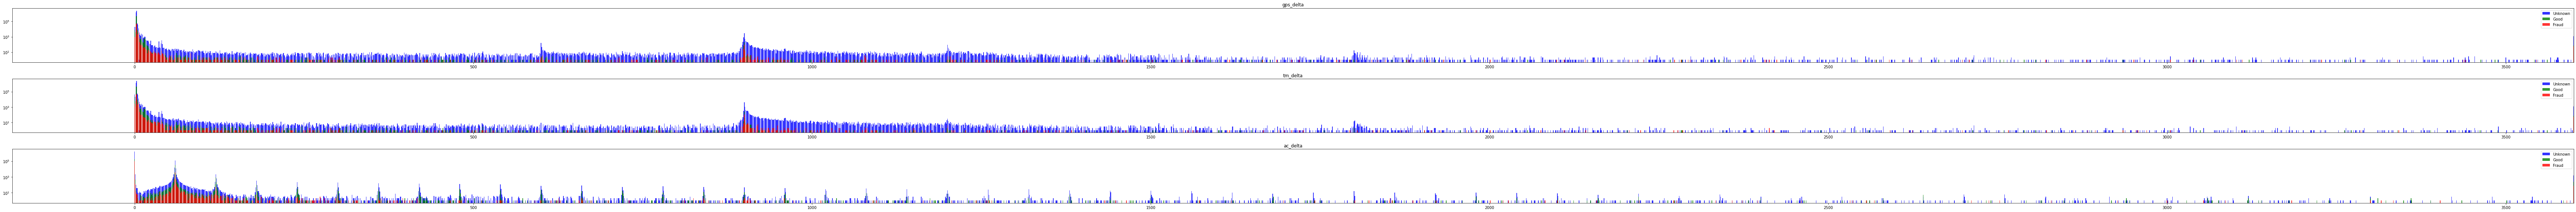

In [14]:
plt.figure(figsize=(96,8))
plt.subplot(311)
plot_fraud_hist(df_gps, "gps_delta")
plt.subplot(312)
plot_fraud_hist(df_gps, "tm_delta")
plt.subplot(313)
plot_fraud_hist(df_accel, "ac_delta")
plt.tight_layout()
plt.show()

### Гистограмма расстояний

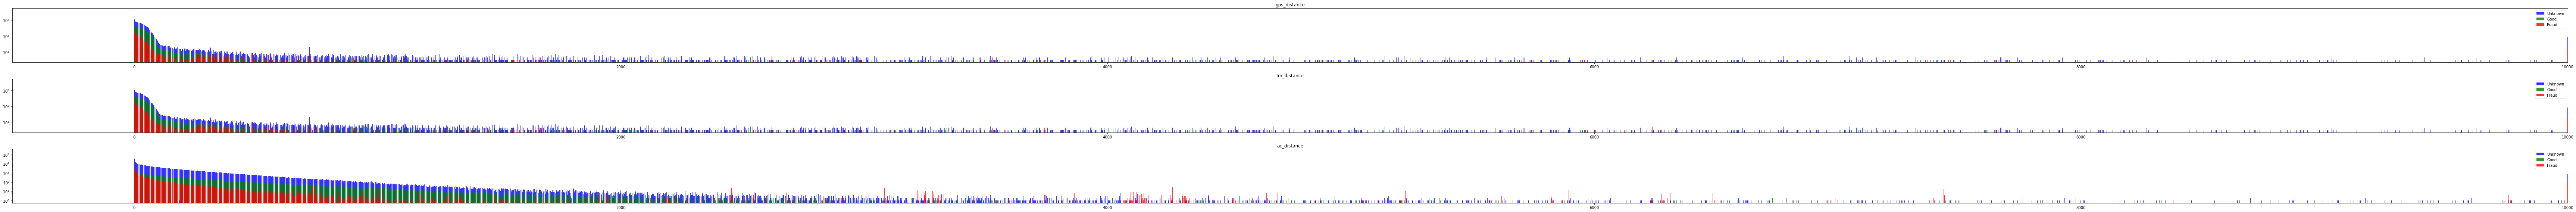

In [15]:
plt.figure(figsize=(96,8))
plt.subplot(311)
plot_fraud_hist(df_gps, "gps_distance")
plt.subplot(312)
plot_fraud_hist(df_gps, "tm_distance")
plt.subplot(313)
plot_fraud_hist(df_accel, "ac_distance")
plt.tight_layout()
plt.show()

### Гистограмма скоростей

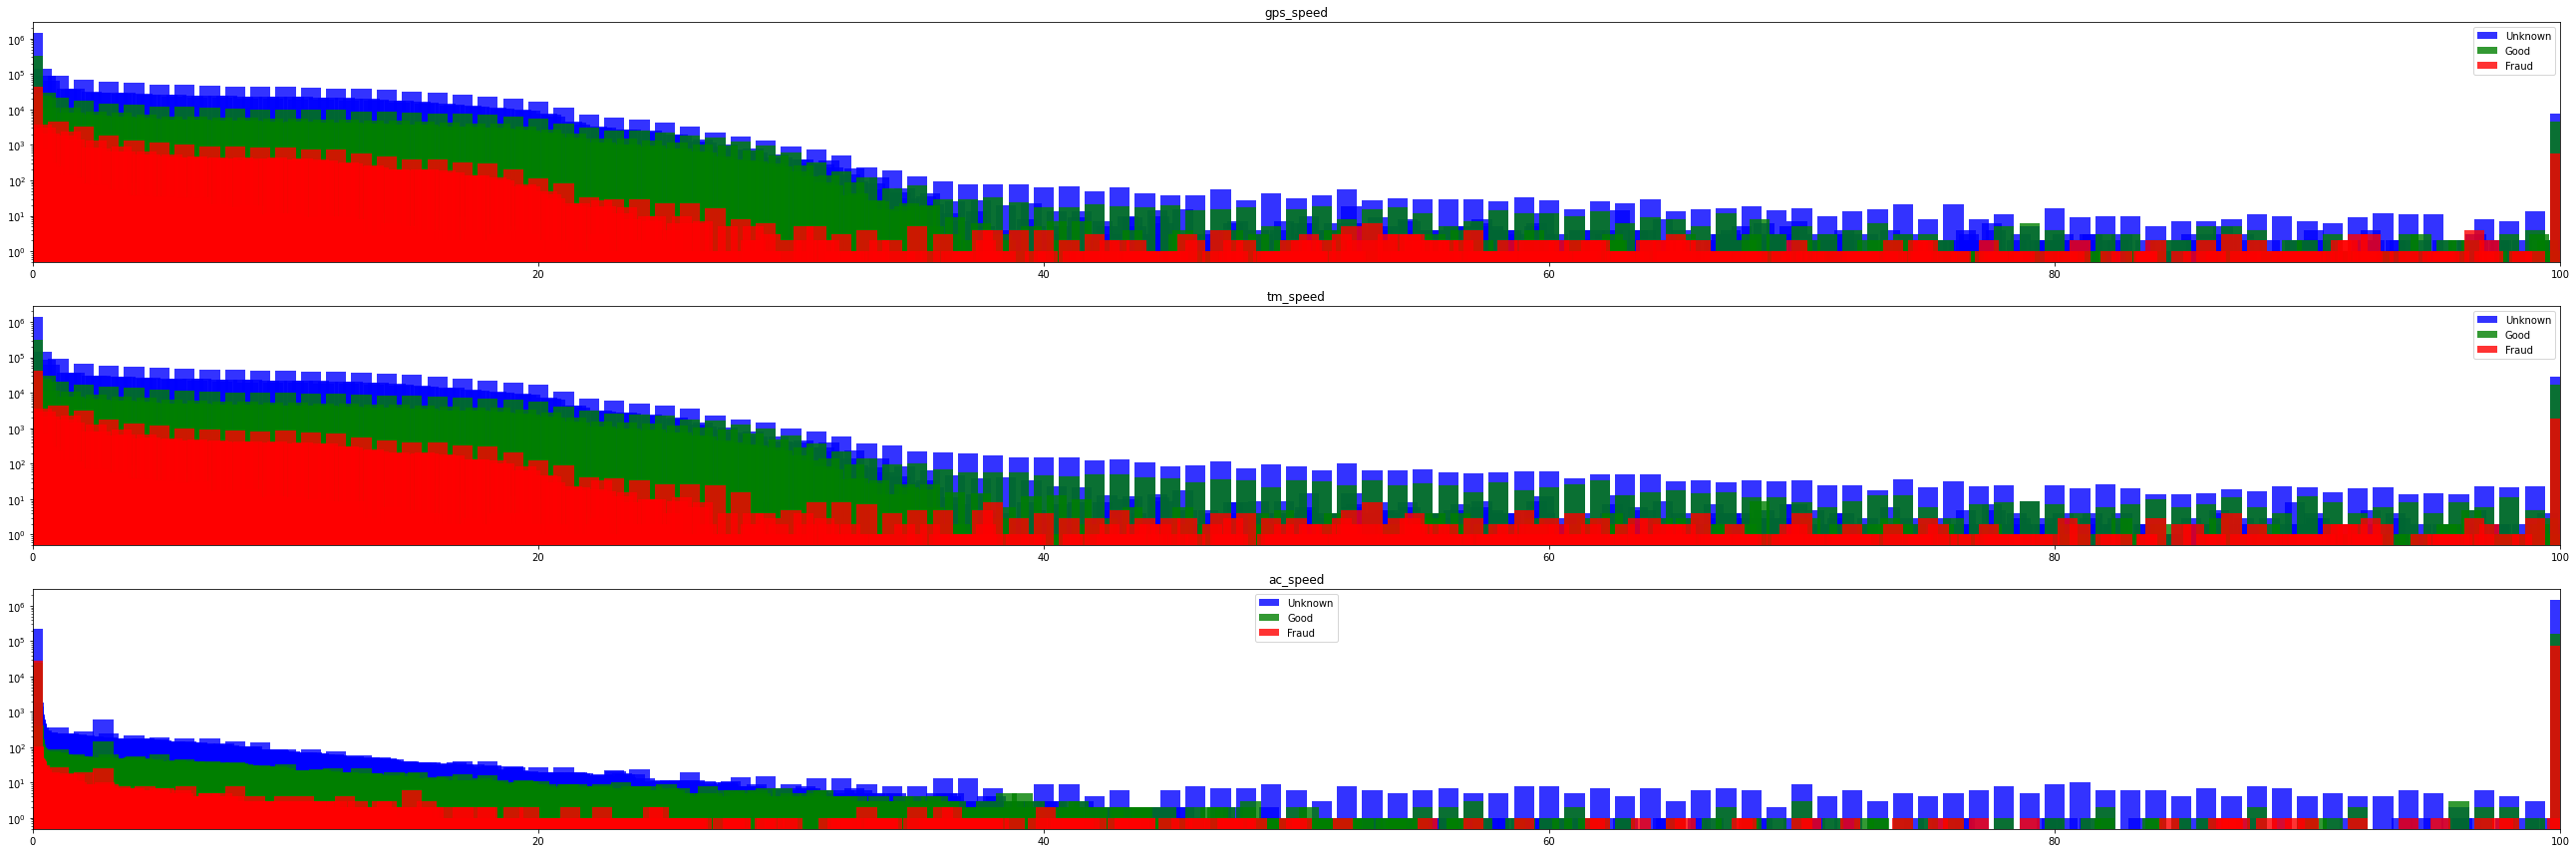

In [16]:
plt.figure(figsize=(36,12))
plt.subplot(311)
plot_fraud_hist(df_gps, "gps_speed")
plt.xlim((0, 100))
plt.subplot(312)
plot_fraud_hist(df_gps, "tm_speed")
plt.xlim((0, 100))
plt.subplot(313)
plot_fraud_hist(df_accel, "ac_speed")
plt.xlim((0, 100))
plt.tight_layout()
plt.show()

### Гистограмма ускорений

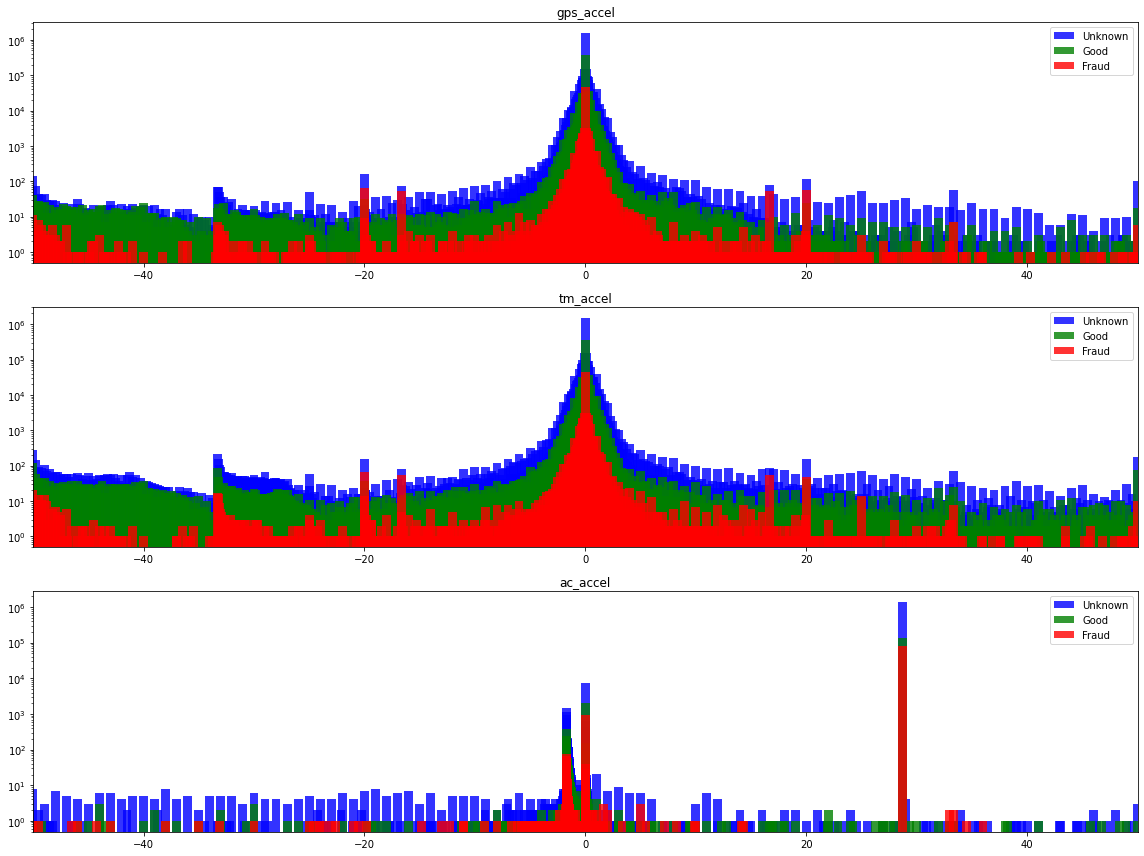

In [17]:
plt.figure(figsize=(16,12))
plt.subplot(311)
plot_fraud_hist(df_gps, "gps_accel")
plt.xlim((-50, 50))
plt.subplot(312)
plot_fraud_hist(df_gps, "tm_accel")
plt.xlim((-50, 50))
plt.subplot(313)
plot_fraud_hist(df_accel, "ac_accel")
plt.xlim((-50, 50))
plt.tight_layout()
plt.show()

## Обзор датасета GPS

In [14]:
describe(df_gps)

,dtypes,count,mean,min,25%,50%,75%,max,std
time,datetime64[ns],5050292,2020-07-31 17:37:31.378776832,2015-03-01 03:00:02,2020-11-20 07:07:20.750000128,2021-03-05 11:16:20,2021-06-03 21:19:25.750000128,2021-08-28 02:47:58,NaN
lat,float64,5.05029e+06,55.743,42.98,55.6674,55.7496,55.8242,82.4343,0.171211
lon,float64,5.05029e+06,37.6021,26.1013,37.5009,37.5848,37.7032,135.46,0.401377
gps_time,datetime64[ns],5050292,2020-07-31 17:37:28.866648576,2015-03-01 03:00:02,2020-11-20 07:07:20.750000128,2021-03-05 11:16:20,2021-06-03 21:19:25.750000128,2021-08-28 02:47:58,NaN
driver_hash,int64,5.05029e+06,3.03558e+17,-9.21858e+18,-4.06958e+18,1.02237e+17,4.79299e+18,9.20647e+18,5.27957e+18
fraud,int64,5.05029e+06,-0.767609,-1,-1,-1,-1,1,0.470076
gps_delta,float64,5.05029e+06,6.85008,0,2,3,3,3600,84.5366
gps_distance,float64,5.05029e+06,19.588,0,0,5,25,10000,180.183
gps_speed,float64,5.05029e+06,5.64977,0,0,2,9.66667,100,8.39405
gps_accel,float64,5.05029e+06,-0.0740194,-100,-0.111111,0,0.111111,100,6.11186


(5050292, 18)

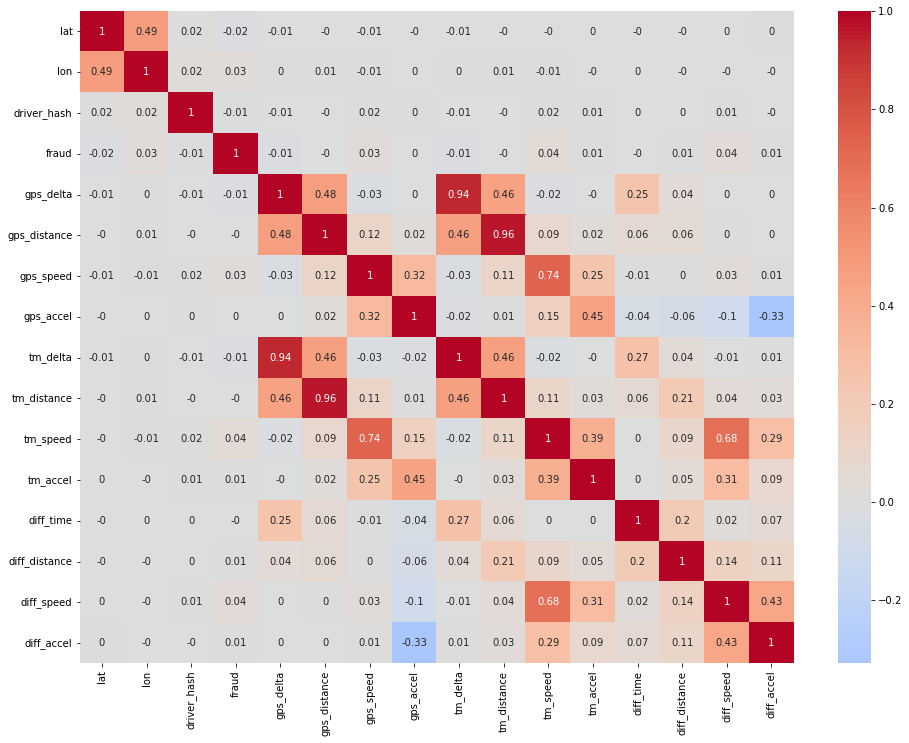

In [15]:
corr = df_gps.corr()

plt.figure(figsize=(16,12))
sns.heatmap(corr, cmap="coolwarm", annot=corr.round(2), center=0)
plt.show()

## Обзор датасета с данными акселерометра

In [16]:
describe(df_accel)

,dtypes,count,mean,min,25%,50%,75%,max,std
time,datetime64[ns],2172989,2020-11-22 12:54:59.282577664,2015-02-28 05:46:43,2020-12-18 06:53:34,2021-03-18 16:54:01,2021-06-12 11:02:19,2021-08-29 00:03:16,NaN
x,float64,2.17299e+06,0.368934,-71.1054,-0.371101,0.184359,0.785298,65.1529,2.36914
y,float64,2.17299e+06,7.6569,-74.7916,7.63271,8.85376,9.50019,55.2294,3.4034
z,float64,2.17299e+06,3.83295,-65.5062,2.01402,3.69992,5.35365,76.4756,2.73072
lat,float64,2.17299e+06,55.7482,55.3163,55.6768,55.7512,55.8214,82.4343,0.16893
lon,float64,2.17299e+06,37.601,36.3143,37.5016,37.5863,37.686,108.856,0.376061
driver_hash,int64,2.17299e+06,-1.12657e+17,-9.21858e+18,-4.47912e+18,-4.14168e+17,4.43147e+18,9.20647e+18,5.3536e+18
fraud,int64,2.17299e+06,-0.796897,-1,-1,-1,-1,1,0.509161
ac_delta,float64,2.17299e+06,11.2106,0,0,0,0,3600,118.59
ac_distance,float64,2.17299e+06,185.61,0,11,77,230,10000,399.524


(2172989, 12)

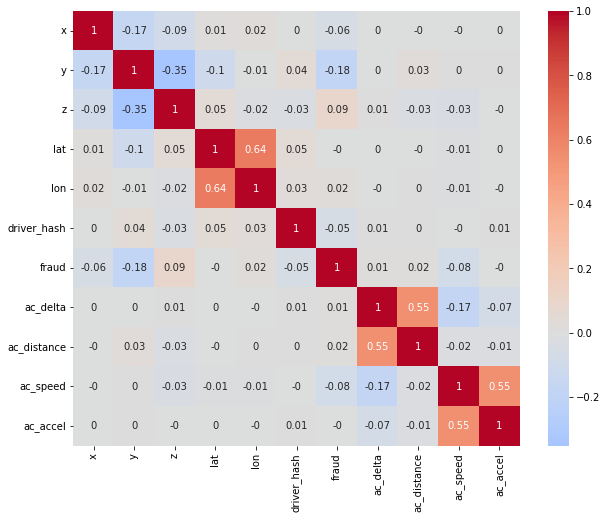

In [17]:
corr = df_accel.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="coolwarm", annot=corr.round(2), center=0)
plt.show()

## Пример отрисовки маршрута

In [10]:
# [None, -1, 0, 1]
FORCE_FRAUD = None

# Выбор случайного водителя
driver_gps, driver_hash, driver_fraud = sample_driver(df_gps, FORCE_FRAUD)
driver_accel = df_accel[df_accel["driver_hash"] == driver_hash]

center = (driver_gps["lat"].mean(), driver_gps["lon"].mean())
m = folium.Map(location=center, zoom_start=10, legend=True)

# Маршрут по данным акселерометра
driver_accel = driver_accel.sort_values(by="time").reset_index(drop=True)
map_driver_points(m, driver_accel, driver_hash, label="accel", color="blue")

# Маршрут по данным  GPS
driver_gps = driver_gps.sort_values(by="gps_time").reset_index(drop=True)
map_driver_points(m, driver_gps, driver_hash, label="gps")


folium.map.LayerControl('topleft', collapsed= False).add_to(m)
m

## PCA на данных GPS

"GPS by 'gps_time' with MimMaxScaling"

,lat,lon,gps_delta,gps_distance,gps_speed,gps_accel
0,-0.000307,-0.000321,-0.007358,0.025471,0.991190,0.129770
1,-0.000334,-0.000398,-0.017979,0.012886,0.129326,-0.991355


"GPS by 'gps_time' with StandardScaling"

,lat,lon,gps_delta,gps_distance,gps_speed,gps_accel
0,-0.138335,-0.124917,0.637240,0.677968,0.249975,0.192499
1,0.692888,0.695671,0.129681,0.135955,0.017655,0.018324


"GPS by 'time' with MimMaxScaling"

,lat,lon,tm_delta,tm_distance,tm_speed,tm_accel
0,-0.000143,-0.000223,-0.004920,0.017607,0.989597,0.142699
1,-0.000227,-0.000279,-0.010257,0.008377,0.142514,-0.989704


"GPS by 'time' with StandardScaling"

,lat,lon,tm_delta,tm_distance,tm_speed,tm_accel
0,-0.152212,-0.141441,0.562150,0.625409,0.372696,0.332829
1,0.689673,0.692429,0.135751,0.147258,0.049307,0.048458


100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


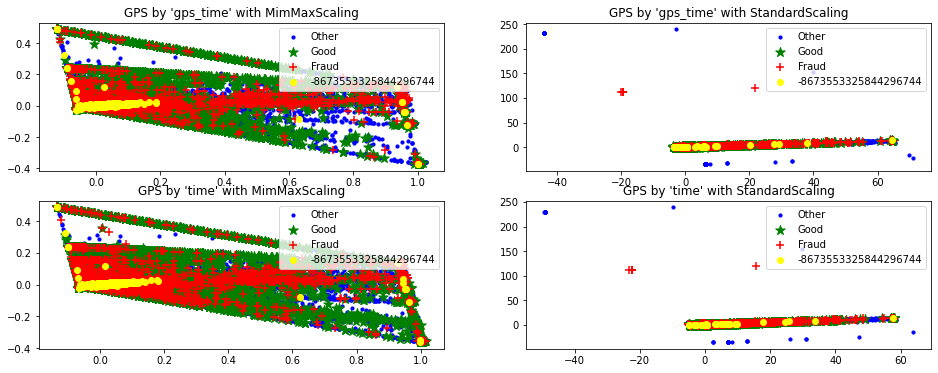

In [11]:
np.random.seed(100)

feats_history = []

X = df_gps[["lat", "lon", "gps_delta", "gps_distance", "gps_speed", "gps_accel"]].copy().fillna(0.0)

# MinMaxScaling
pca = PCA(n_components=2)
feats = pca.fit_transform(MinMaxScaler().fit_transform(X))
feats_history.append(pd.DataFrame(feats, columns=["gps_time", "MimMaxScaling"]))
display(f"GPS by '{feats_history[-1].columns[0]}' with {feats_history[-1].columns[1]}")
display(pd.DataFrame(pca.components_, columns=X.columns))

# StandardScaling
pca = PCA(n_components=2)
feats = pca.fit_transform(StandardScaler().fit_transform(X))
feats_history.append(pd.DataFrame(feats, columns=["gps_time", "StandardScaling"]))
display(f"GPS by '{feats_history[-1].columns[0]}' with {feats_history[-1].columns[1]}")
display(pd.DataFrame(pca.components_, columns=X.columns))


X = df_gps[["lat", "lon", "tm_delta", "tm_distance", "tm_speed", "tm_accel"]].copy().fillna(0.0)

# MinMaxScaling
pca = PCA(n_components=2)
feats = pca.fit_transform(MinMaxScaler().fit_transform(X))
feats_history.append(pd.DataFrame(feats, columns=["time", "MimMaxScaling"]))
display(f"GPS by '{feats_history[-1].columns[0]}' with {feats_history[-1].columns[1]}")
display(pd.DataFrame(pca.components_, columns=X.columns))

# StandardScaling
pca = PCA(n_components=2)
feats = pca.fit_transform(StandardScaler().fit_transform(X))
feats_history.append(pd.DataFrame(feats, columns=["time", "StandardScaling"]))
display(f"GPS by '{feats_history[-1].columns[0]}' with {feats_history[-1].columns[1]}")
display(pd.DataFrame(pca.components_, columns=X.columns))

plt.figure(figsize=(16,6))
i = 221
for feats in tqdm(feats_history):
    plt.subplot(i)
    title = f"GPS by '{feats.columns[0]}' with {feats.columns[1]}"
    plot_fraud_pca(df_gps, feats.values, driver_hash, title)
    i += 1
plt.show()

'GPS with MimMaxScaling'

,lat,lon,gps_delta,gps_distance,gps_speed,gps_accel,diff_time,diff_distance,diff_speed,diff_accel,tm_delta,tm_distance,tm_speed,tm_accel
0,-0.000118,-0.000186,-0.003300,0.011570,0.450867,0.039007,0.000193,0.003139,0.359918,0.075379,-0.003993,0.014651,0.804388,0.112025
1,0.000271,0.000131,0.005219,-0.017515,-0.666426,-0.131976,0.003149,0.006621,0.708280,0.183475,0.004312,-0.011028,0.042320,0.028572


'GPS with StandardScaling'

,lat,lon,gps_delta,gps_distance,gps_speed,gps_accel,diff_time,diff_distance,diff_speed,diff_accel,tm_delta,tm_distance,tm_speed,tm_accel
0,-0.004594,0.002962,0.467263,0.479591,0.113908,0.029501,0.166917,0.118165,0.097024,0.063447,0.467061,0.485894,0.146186,0.083122
1,-0.003560,-0.009018,-0.177030,-0.070572,0.411215,0.192183,-0.051057,0.074248,0.423096,0.223951,-0.179985,-0.049848,0.578490,0.388253


100%|██████████| 2/2 [00:00<00:00,  2.10it/s]


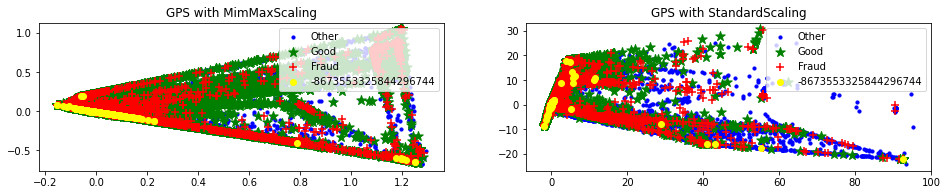

In [12]:
np.random.seed(100)

feats_history = []

X = df_gps[["lat", "lon", 
            "gps_delta", "gps_distance", "gps_speed", "gps_accel",
            "diff_time", "diff_distance", "diff_speed", "diff_accel",
            "tm_delta", "tm_distance", "tm_speed", "tm_accel",
           ]].copy().fillna(0.0)

# MinMaxScaling
pca = PCA(n_components=2)
feats = pca.fit_transform(MinMaxScaler().fit_transform(X))
feats_history.append(pd.DataFrame(feats, columns=["all", "MimMaxScaling"]))
display(f"GPS with {feats_history[-1].columns[1]}")
display(pd.DataFrame(pca.components_, columns=X.columns))

# StandardScaling
pca = PCA(n_components=2)
feats = pca.fit_transform(StandardScaler().fit_transform(X))
feats_history.append(pd.DataFrame(feats, columns=["all", "StandardScaling"]))
display(f"GPS with {feats_history[-1].columns[1]}")
display(pd.DataFrame(pca.components_, columns=X.columns))


plt.figure(figsize=(16,6))
i = 221
for feats in tqdm(feats_history):
    plt.subplot(i)
    title = f"GPS with {feats.columns[1]}"
    plot_fraud_pca(df_gps, feats.values, driver_hash, title)
    i += 1
plt.show()

## PCA на данных акселерометра

'Accel with MimMaxScaling'

,lat,lon,x,y,z,ac_delta,ac_distance,ac_speed,ac_accel
0,0.000116,0.000125,0.000078,-0.000208,0.001328,0.013378,0.001594,-0.959279,-0.282135
1,-0.000288,-0.000171,-0.000334,-0.000118,-0.002277,-0.009704,0.001071,0.282020,-0.959356


'Accel with StandardScaling'

,lat,lon,x,y,z,ac_delta,ac_distance,ac_speed,ac_accel
0,0.134751,0.134526,0.005238,-0.021716,0.029824,0.524468,0.434072,-0.521191,-0.476687
1,0.680058,0.658388,0.062076,-0.204791,0.131256,-0.127267,-0.124487,0.067336,0.069264


100%|██████████| 2/2 [00:00<00:00,  4.36it/s]


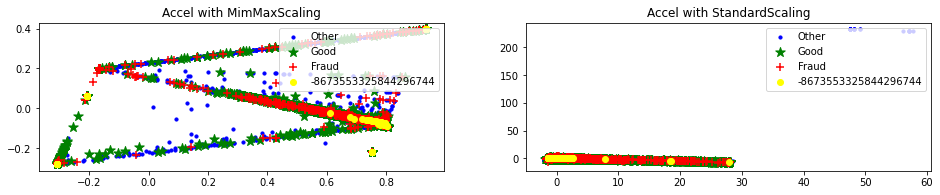

In [13]:
np.random.seed(100)

feats_history = []

X = df_accel[["lat", "lon", "x", "y", "z",
            "ac_delta", "ac_distance", "ac_speed", "ac_accel",
           ]].copy().fillna(0.0)

# MinMaxScaling
pca = PCA(n_components=2)
feats = pca.fit_transform(MinMaxScaler().fit_transform(X))
feats_history.append(pd.DataFrame(feats, columns=["all", "MimMaxScaling"]))
display(f"Accel with {feats_history[-1].columns[1]}")
display(pd.DataFrame(pca.components_, columns=X.columns))

# StandardScaling
pca = PCA(n_components=2)
feats = pca.fit_transform(StandardScaler().fit_transform(X))
feats_history.append(pd.DataFrame(feats, columns=["all", "StandardScaling"]))
display(f"Accel with {feats_history[-1].columns[1]}")
display(pd.DataFrame(pca.components_, columns=X.columns))


plt.figure(figsize=(16,6))
i = 221
for feats in tqdm(feats_history):
    plt.subplot(i)
    title = f"Accel with {feats.columns[1]}"
    plot_fraud_pca(df_accel, feats.values, driver_hash, title)
    i += 1
plt.show()

'Accel with MimMaxScaling'

,lat,lon,x,y,z,ac_delta,ac_distance,ac_speed,ac_accel,sin_x,cos_x,sin_y,cos_y,sin_z,cos_z,sum_x,sum_y,sum_z
0,3.847589e-11,1.398955e-11,1.158772e-10,-2.766712e-10,5.972833e-11,5.653450e-12,-1.485065e-10,1.372032e-10,1.617908e-11,-1.518649e-09,7.389546e-10,-1.611664e-09,-7.857650e-09,2.202333e-09,-3.028458e-09,0.050685,0.888190,0.456673
1,-8.655693e-10,-1.977585e-10,-1.566405e-08,-1.500484e-08,2.435659e-08,5.377967e-10,-7.631797e-09,-5.629151e-08,1.683406e-09,-4.389944e-07,-3.073368e-07,-2.205721e-07,5.133369e-07,1.230287e-08,2.081517e-07,0.160263,-0.458568,0.874089


'Accel with StandardScaling'

,lat,lon,x,y,z,ac_delta,ac_distance,ac_speed,ac_accel,sin_x,cos_x,sin_y,cos_y,sin_z,cos_z,sum_x,sum_y,sum_z
0,6.176449e-09,2.698555e-09,6.664552e-09,-1.056974e-08,3.105531e-09,1.716204e-10,-3.717085e-09,3.388601e-10,8.654668e-11,-1.518649e-09,7.389546e-10,-1.611664e-09,-7.857650e-09,2.202333e-09,-3.028458e-09,0.050685,0.888190,0.456673
1,-1.389480e-07,-3.814719e-08,-9.009013e-07,-5.732337e-07,1.266403e-06,1.632576e-08,-1.910222e-07,-1.390270e-07,9.005036e-09,-4.389944e-07,-3.073368e-07,-2.205721e-07,5.133369e-07,1.230287e-08,2.081517e-07,0.160263,-0.458568,0.874089


100%|██████████| 2/2 [00:00<00:00,  3.95it/s]


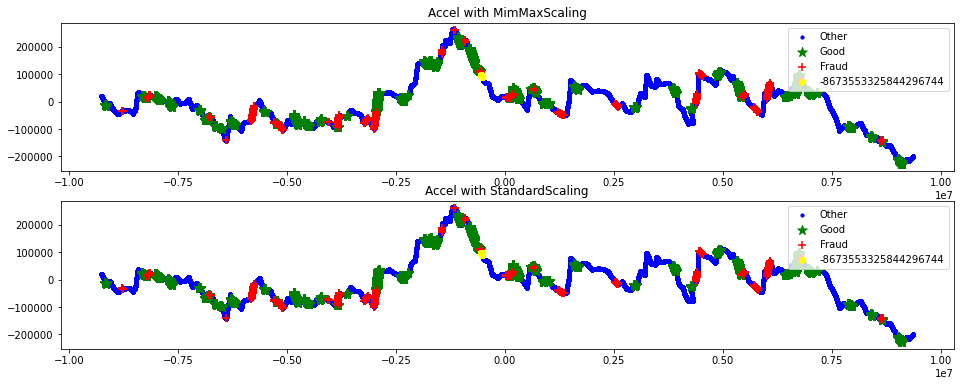

In [14]:
np.random.seed(100)

feats_history = []

X = df_accel[["lat", "lon", "x", "y", "z",
            "ac_delta", "ac_distance", "ac_speed", "ac_accel",
           ]].copy().fillna(0.0)

Z = pd.concat((
        np.sin(df_accel["x"]),
        np.cos(df_accel["x"]),
        np.sin(df_accel["y"]),
        np.cos(df_accel["y"]),
        np.sin(df_accel["z"]),
        np.cos(df_accel["z"]),
        np.cumsum(df_accel["x"]),
        np.cumsum(df_accel["y"]),
        np.cumsum(df_accel["z"]),
    ), axis=1)

Z.columns = ["sin_x", "cos_x", "sin_y", 
             "cos_y", "sin_z", "cos_z", 
             "sum_x", "sum_y", "sum_z"]

# Z["sum_sin_x"] = np.cumsum(Z["sin_x"])
# Z["sum_cos_x"] = np.cumsum(Z["cos_x"])
# Z["sum_sin_y"] = np.cumsum(Z["sin_y"])
# Z["sum_cos_y"] = np.cumsum(Z["cos_y"])
# Z["sum_sin_z"] = np.cumsum(Z["sin_z"])
# Z["sum_cos_z"] = np.cumsum(Z["cos_z"])

# MinMaxScaling
XS = MinMaxScaler().fit_transform(X)
XS = pd.DataFrame(XS, columns=X.columns).merge(Z, left_index=True, right_index=True)
pca = PCA(n_components=2)
feats = pca.fit_transform(XS)
feats_history.append(pd.DataFrame(feats, columns=["all", "MimMaxScaling"]))
display(f"Accel with {feats_history[-1].columns[1]}")
display(pd.DataFrame(pca.components_, columns=XS.columns))

# StandardScaling
XS = StandardScaler().fit_transform(X)
XS = pd.DataFrame(XS, columns=X.columns).merge(Z, left_index=True, right_index=True)
pca = PCA(n_components=2)
feats = pca.fit_transform(XS)
feats_history.append(pd.DataFrame(feats, columns=["all", "StandardScaling"]))
display(f"Accel with {feats_history[-1].columns[1]}")
display(pd.DataFrame(pca.components_, columns=XS.columns))


plt.figure(figsize=(16,6))
i = 211
for feats in tqdm(feats_history):
    plt.subplot(i)
    title = f"Accel with {feats.columns[1]}"
    plot_fraud_pca(df_accel, feats.values, driver_hash, title)
    i += 1
plt.show()